In [44]:
from __future__ import print_function
import numpy as np
import torch
import torch.autograd as ag

from matplotlib import pyplot
from tqdm import trange
import pandas as pd

import cv2
import glob

In [45]:
categories = glob.glob('pokemon/PokemonTypesDeepLearning/Images/data/*')
xtrain = []
ltrain = []
for cat in categories:
    image_files = glob.glob(cat + "/*")
    for image in image_files:
        img = cv2.imread(image)
        if img.shape == (32, 32, 3):
            xtrain.append(img)
            ltrain.append(cat.split("/")[-1])
        

In [47]:
# len(xtrain), len(ltrain), [xtrain[i].shape for i in range(len(ltrain))]

In [49]:
xtrain = np.array(xtrain)
ltrain = np.array(ltrain)

In [50]:
classes = list(set(ltrain))
print(classes)
tmp = dict(zip(classes, range(len(classes))))
inds = map(lambda x:tmp[x], ltrain)
one_hot = np.zeros((len(ltrain), len(classes)))
one_hot[range(len(ltrain)), inds] = 1
one_hot.sum(axis=0)
ltrain = one_hot

['Ghost', 'Steel', 'Poison', 'Electric', 'Normal', 'Fire', 'Psychic', 'Water', 'Ice', 'Dragon', 'Dark', 'Fighting', 'Rock', 'Fairy', 'Grass', 'Bug', 'Ground']


In [51]:
xtrain = np.moveaxis(xtrain, [1, 2, 3], [2, 3, 1])


In [52]:
val_idx = np.random.uniform(size=(len(xtrain),)) < 0.2
xval = xtrain[val_idx]
lval = ltrain[val_idx]
neg = (1-val_idx).astype(bool)
xtrain = xtrain[neg]
ltrain = ltrain[neg]

In [53]:
ltrain.shape, lval.shape

((581, 17), (133, 17))

In [54]:
xtrain = torch.from_numpy(xtrain).double()
ltrain = torch.from_numpy(ltrain).long()
xval = torch.from_numpy(xval).double()
lval = torch.from_numpy(lval).long()

if torch.cuda.is_available():
    xtrain = xtrain.cuda()
    ltrain = ltrain.cuda()
    xval = xval.cuda()
    lval = lval.cuda()

    
xtrain = ag.Variable(xtrain, requires_grad=True)
ltrain = ag.Variable(ltrain, requires_grad=False)
xval = ag.Variable(xval, requires_grad=False)
lval = ag.Variable(lval, requires_grad=False)

In [55]:
import torch.nn as nn
import torch.nn.functional as F
# This is our neural networks class that inherits from nn.Module 
class LeNet(nn.Module):
# Here we define our network structure
    def __init__(self):
        super(LeNet , self).__init__ () 
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2).double()
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2).double()
        self.fc1 = nn.Linear(4096, 120).double() 
        self.fc2 = nn.Linear(120, 84).double() 
        self.fc3 = nn.Linear(84, len(classes)).double()

    # Here we define one forward pass through the network 
    def forward(self , x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         print(x.size())
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) 
        return x

    # Determine the number of features in a batch of tensors 
    def num_flat_features(self , x):
        size = x.size()[1:]
        return np.prod(size)

net = LeNet()
print(net)
if torch.cuda.is_available():
    net=net.cuda()

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=17, bias=True)
)


In [56]:
yinit = net(xval)
if torch.cuda.is_available():
    yinit = yinit.cpu()

In [57]:
yinit.data.numpy().shape
lval.shape

torch.Size([133, 17])

In [58]:
print (100 * np.mean(lval.cpu().data.numpy().T.argmax(axis=0) == yinit.data.numpy().T.argmax(axis =0)))

10.526315789473683


In [59]:
import math


N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 50
# T = 1
gamma = .001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(net.parameters(), lr=gamma , momentum=rho)

In [60]:
losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = ltrain[idxsmp]
        # Initialize the gradients to zero 
        optimizer.zero_grad ()

        # Forward propagation 
        outputs = net(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)
        
        loss = criterion(outputs , torch.max(labels, 1)[1])
        
        # Back propagation 
        loss.backward()

        # Parameter update 
        optimizer.step()
        
        voutputs = net(xval)
        vloss = criterion(voutputs , torch.max(lval, 1)[1])

        # Print averaged loss per minibatch every 100 mini-batches
        running_loss+= loss[0] 
#         print(k)
        losses.append((running_loss.cpu().data.numpy()[0], vloss[0].cpu().data.numpy()[0]))
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f ' % (epoch + 1, k + 1, running_loss), end="")
            running_loss = 0.0 

print ( ' Finished Training ' )
# pd.Series(losses).ewm(20).mean().plot()

[50,    30] loss: 0.00003015  Finished Training 


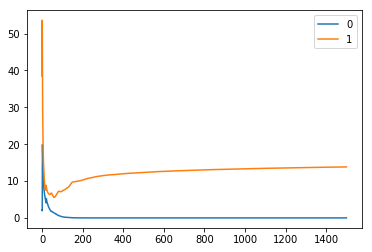

In [61]:
pd.DataFrame(losses).ewm(20).mean().plot()

In [62]:
# np.random.permutation(NB)
ytrained = net(xval)
if torch.cuda.is_available():
    ytrained = ytrained.cpu()
    
print (100 * np.mean(lval.T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis =0)))

AttributeError: 'Variable' object has no attribute 'T'

Initialized empty Git repository in /datasets/home/26/626/ee285fac/.git/
